In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matrix2 = pd.read_csv('matrix_for_cluster.csv', index_col=0)

data = matrix2.values
data2 = np.zeros((data.shape[0],data.shape[1]),dtype = int)
eng_len = np.zeros(data.shape[0])
ctr = 0;

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if (data[i][j] != 2):
            data2[i][:len(data[i][j:])] = data[i][j:]
            eng_len[i]= len(data[i][j:])
            ctr = ctr + 1
            break;
            
print(np.amax(eng_len))

43.0


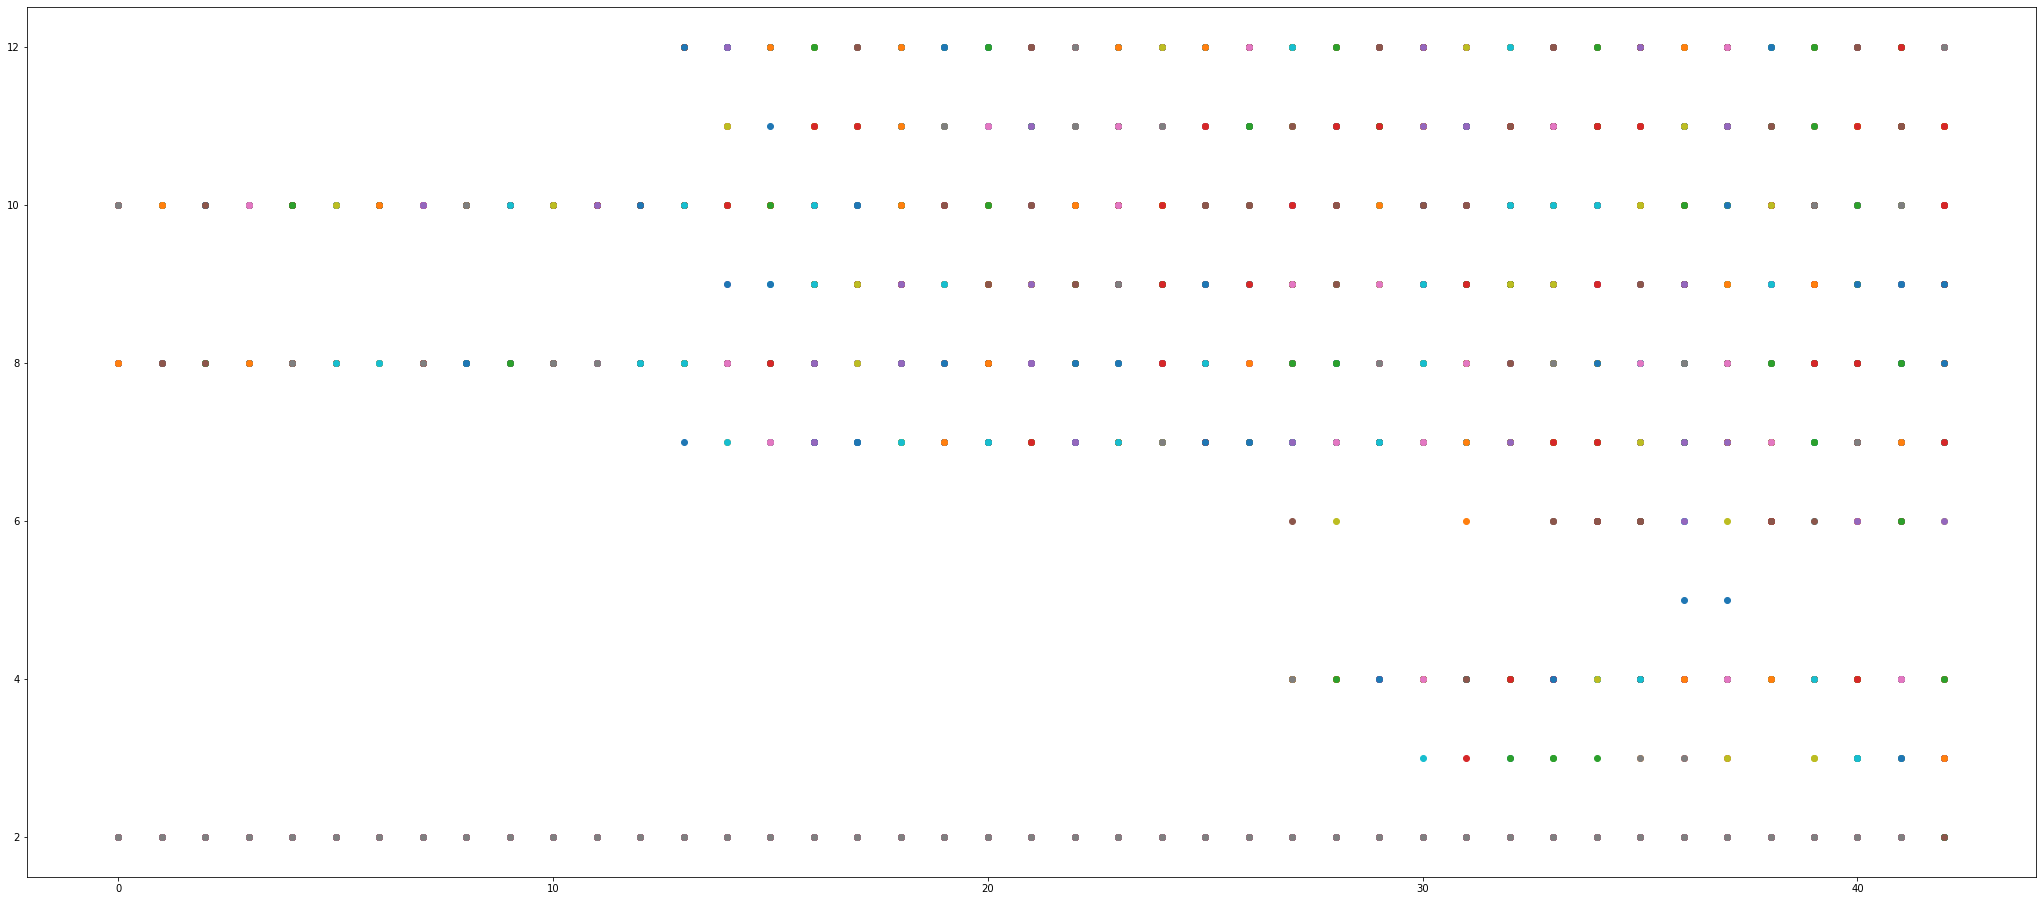

In [6]:
y = values
x = list(range(values.shape[1]))


fig, ax = plt.subplots()
fig.set_size_inches(36, 16)

for i in range(len(y)):
    ax.scatter(x, y[i])

plt.show()

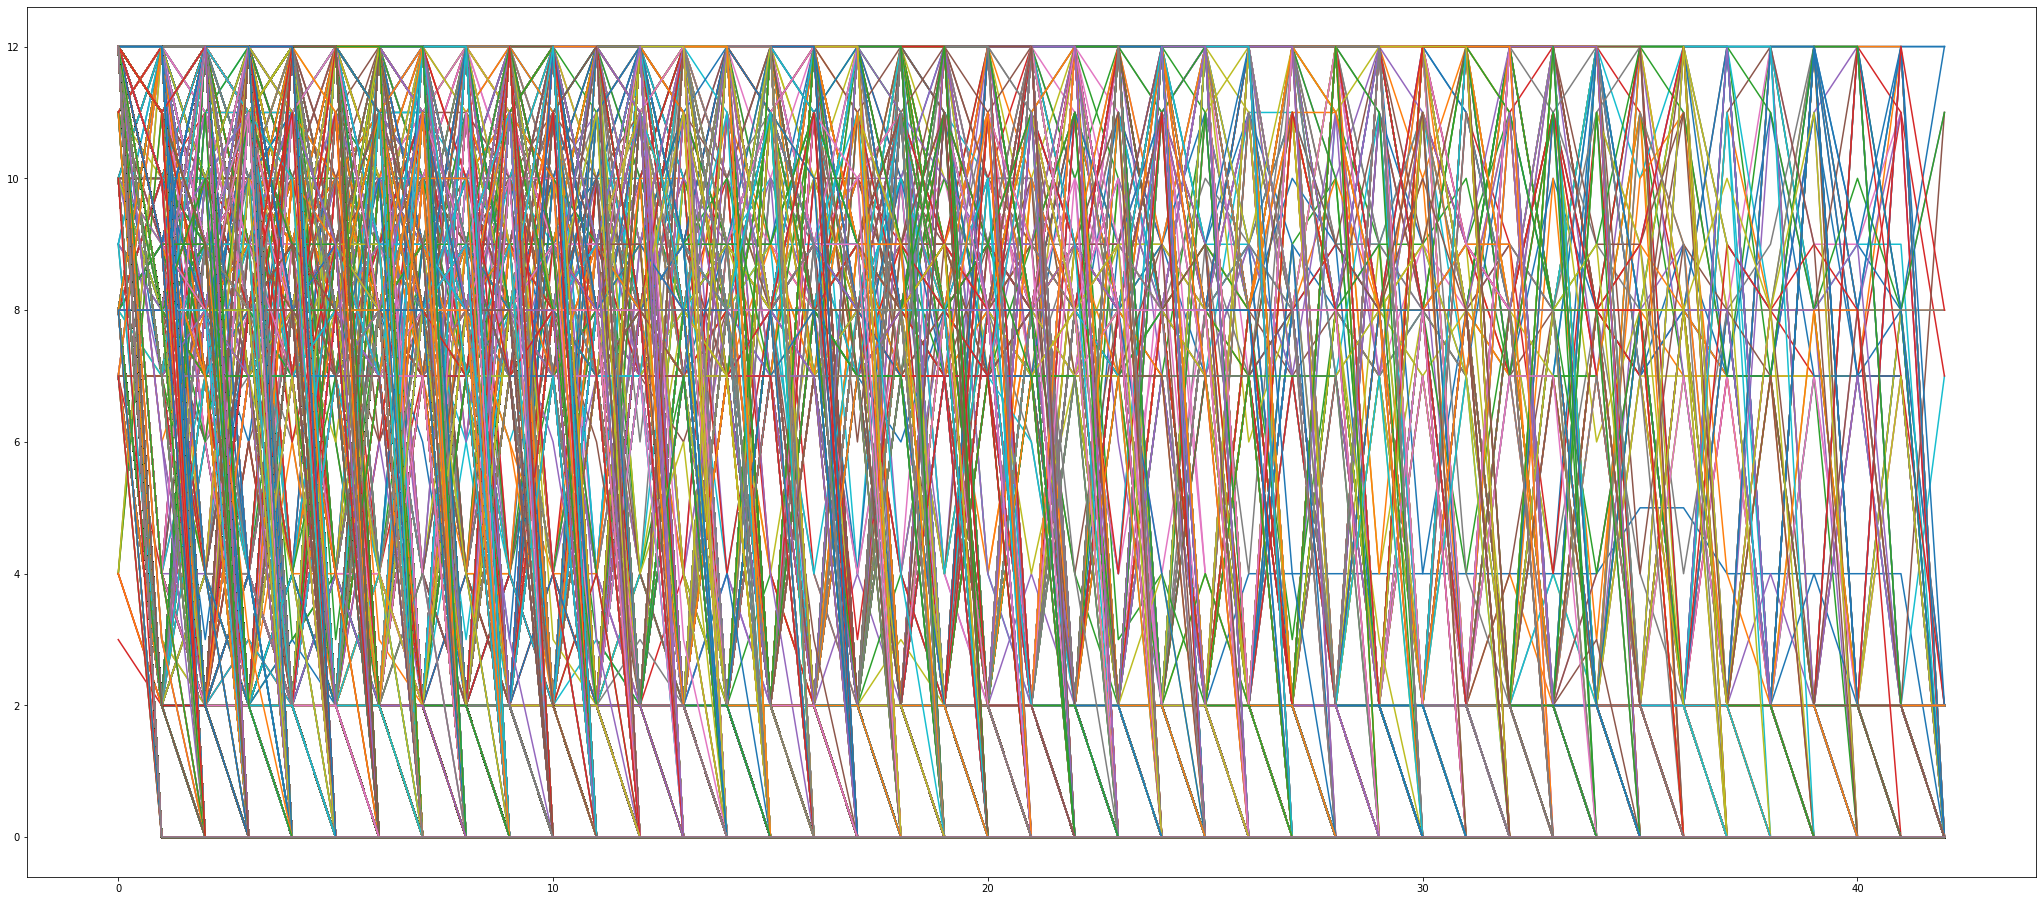

In [90]:
y = data2
x = list(range(data.shape[1]))


fig, ax = plt.subplots()
fig.set_size_inches(36, 16)

for i in range(len(y)):
    ax.plot(x, y[i])

plt.show()

In [80]:
values_long = pd.read_csv('matrix_r.csv', index_col = 0)
values_long.head()
# values_long = values_long[['month','eng']]

y = values_long.eng.values

a = list(range(len(values_long.patient.unique())))
b = list(range(len(values_long.month.unique())))

c = [(i,j) 
    for i in a
    for j in b]

pd_t = pd.DataFrame(c)
pd_t[2] = pd_t.iloc[:,1]

x = pd_t[[1,2]].to_numpy()
periods = len(values_long.month.unique())

In [81]:
import torch
torch.manual_seed(0)
#if you don't have a GPU change this to cpu
#it runs pretty fast either way with this small of data
#device = torch.device("cpu")
device = torch.device("cpu")
##############################################
#Adapted heavily from
#https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html

class LatGBTM(torch.nn.Module):
    def __init__(self, groups, poly, obs, periods):
        """
        Construct parameters for the coefficients and the 
        latent groups 
        Note that poly includes the intercept, so a quadratic
        function should be poly=3
        """
        super(LatGBTM, self).__init__()
        self.coef = torch.nn.Linear(groups, poly, bias=False)
        self.latent_flat = torch.nn.Linear(groups, obs, bias=False)
        #setting the default weights for latent to equal prob
        #torch.nn.init.constant_(self.latent_flat, 1/float(groups))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        #here periods could also be long tensor with varying N
        latent_expand = self.latent_flat.weight.repeat_interleave(periods, -2)
        #softmax to scale probabilities to sum to 1
        pred_groups = torch.mm(x, self.coef.weight) * torch.nn.functional.softmax(latent_expand, 1)
        #sum up to get the final predictions!
        y_pred = torch.sum(pred_groups, 1)
        return y_pred
        

#Set up a basic object
model = LatGBTM(groups=2, poly=3, obs=100, periods=11)
#Initialize latent weights to equal probability (maybe do 0 here instead?)
torch.nn.init.constant_(model.latent_flat.weight, 1/float(2))
criterion = torch.nn.MSELoss(reduction='sum')
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
#SGD converged faster, but not even close right answers!
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#Now create the data tensors for my input data (time points)
#And outcome data
x_ten = torch.Tensor(x)
y_ten = torch.Tensor(y)

#Needs alot of iterations to converge!
for t in range(30000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_ten)

    # Compute and print loss
    loss = criterion(y_pred, y_ten)
    if t % 1000 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
##############################################

RuntimeError: mat1 and mat2 shapes cannot be multiplied (553324x2 and 3x2)

In [49]:
x_ten

tensor([ 0.,  1.,  2.,  ..., 40., 41., 42.])